In [1]:
print("test")

test


In [2]:
from pathlib import Path
import ppgs
from json import load
import numpy as np
from matplotlib import pyplot as plt

/home/cameron/conda/envs/p/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
eval_dir = Path(ppgs.EVAL_DIR)
models = [
    'bottleneck',
    'encodec',
    'mel',
    'w2v2fb',
    'w2v2fc',
    'w2v2fc-pretrained',
    'w2v2ft',
    # 'w2v2fb-ctc'
]
eval_files = {model: eval_dir / model / 'overall-test.json' for model in models}

In [4]:
evals = {}
for model, eval_file in eval_files.items():
    with open(eval_file, 'r') as f:
        evals[model] = load(f)

In [5]:
timit_accuracies = {
    model: evals[model]['timit']['Accuracy/per-dataset'] for model in models
}
arctic_accuracies = {
    model: evals[model]['arctic']['Accuracy/per-dataset'] for model in models
}
common_voice_accuracies = {
    model: evals[model]['charsiu']['Accuracy/per-dataset'] for model in models
}

In [6]:
timit_accuracies

{'bottleneck': 0.5916703343391418,
 'encodec': 0.6410413384437561,
 'mel': 0.5334274172782898,
 'w2v2fb': 0.7118264436721802,
 'w2v2fc': 0.5575138330459595,
 'w2v2fc-pretrained': 0.7380235195159912,
 'w2v2ft': 0.3890034854412079}

In [7]:
arctic_accuracies

{'bottleneck': 0.6496594548225403,
 'encodec': 0.7502590417861938,
 'mel': 0.7033655047416687,
 'w2v2fb': 0.767558753490448,
 'w2v2fc': 0.6226139664649963,
 'w2v2fc-pretrained': 0.7758631706237793,
 'w2v2ft': 0.44117701053619385}

In [8]:
common_voice_accuracies

{'bottleneck': 0.7861724495887756,
 'encodec': 0.8202138543128967,
 'mel': 0.8554689884185791,
 'w2v2fb': 0.8309870362281799,
 'w2v2fc': 0.8784779906272888,
 'w2v2fc-pretrained': 0.6586368680000305,
 'w2v2ft': 0.5305561423301697}

In [9]:
average_accuracies = {}
for model in models:
    average_accuracies[model] = 0
    average_accuracies[model] += timit_accuracies[model]
    average_accuracies[model] += arctic_accuracies[model]
    average_accuracies[model] += common_voice_accuracies[model]
    average_accuracies[model] /= 3

In [10]:
average_accuracy_items = list(average_accuracies.items())
indices = list(reversed(np.argsort([item[1] for item in average_accuracy_items])))
indices

[3, 1, 5, 2, 4, 0, 6]

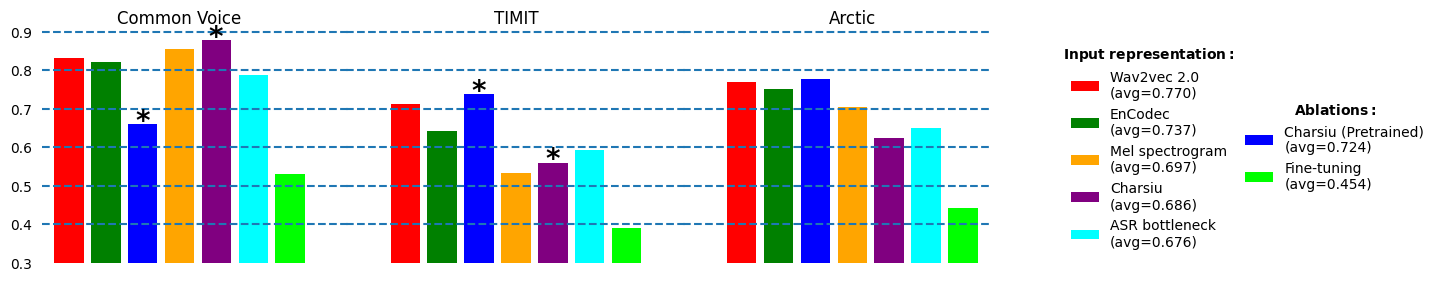

In [25]:
model_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'lime', 'magenta']
label_map = {
    'bottleneck': 'ASR bottleneck',
    'encodec': 'EnCodec',
    'mel': 'Mel spectrogram',
    'w2v2fb': 'Wav2vec 2.0',
    'w2v2fc': 'Charsiu',
    'w2v2fc-pretrained': 'Charsiu (Pretrained)',
    # 'w2v2fb-ctc': 'CTC loss',
    'w2v2ft': 'Fine-tuning'
}
asterisked = [
    ('Common Voice', 'w2v2fc'),
    ('Common Voice', 'w2v2fc-pretrained'),
    ('TIMIT', 'w2v2fc'),
    ('TIMIT', 'w2v2fc-pretrained')
]
top_legend_models = ['bottleneck', 'encodec', 'mel', 'w2v2fb', 'w2v2fc']
bottom_legend_models = [m for m in models if m not in top_legend_models]
figure, axes = plt.subplots(1, 4, sharey=True, figsize=(18, 3), width_ratios=[1, 1, 1, 1.4])
datasets = ['Common Voice', 'TIMIT', 'Arctic']
inter_figure_distance = 0.115
for i, accuracies in enumerate([common_voice_accuracies, timit_accuracies, arctic_accuracies]):
    ax = axes[i]
    ax.set_ylim(0.3, 0.9)
    for pos in ['top', 'bottom', 'left', 'right']:
        ax.spines[pos].set_visible(False)
    ax.tick_params(left=False, bottom=False)
    bar = ax.bar(range(len(accuracies)), [list(accuracies.values())[idx] for idx in indices], align='center', color=model_colors)
    # ax.set_xticks(range(len(accuracies)), list(accuracies.keys()), rotation=45, rotation_mode='anchor', ha='right')
    ax.set_xticks(range(len(accuracies)), [label_map[k] for k in accuracies.keys()], rotation=45, rotation_mode='anchor', ha='right', visible=False)
    ax.set_title(f'{datasets[i]}')
    if i == 0:
        xmin = 0
        xmax = 1 + inter_figure_distance
    elif i == len(datasets) - 1:
        xmin = 0 - inter_figure_distance
        xmax = 1
    else:
        xmin = 0 - inter_figure_distance
        xmax = 1 + inter_figure_distance
    for y in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        ax.axhline(y, linestyle='dashed', clip_on=False, xmin=xmin, xmax=xmax)

    for dataset, model in asterisked:
        if dataset == datasets[i]:
            idx = indices.index(models.index(model))
            current_bar = list(bar)[idx]
            ax.text(
                current_bar.get_x() + current_bar.get_width()/2.0,
                current_bar.get_height()*0.99,
                r'$\bf{*}$',
                ha='center',
                va='baseline',
                fontsize=20
            )

lax = axes[-1]
lax.axis('off')
legend_labels = [label_map[models[idx]] + f'\n(avg={average_accuracy_items[idx][1]:.3f})' for idx in indices]
top_legend = lax.legend(
    [b for i, b in enumerate(bar) if models[indices[i]] in top_legend_models],
    [l for i, l in enumerate(legend_labels) if models[indices[i]] in top_legend_models],
    loc='center left',
    title=r'$\bf{Input\ representation:}$',
    frameon=False
)
lax.add_artist(top_legend)
lax.legend(
    [b for i, b in enumerate(bar) if models[indices[i]] in bottom_legend_models],
    [l for i, l in enumerate(legend_labels) if models[indices[i]] in bottom_legend_models],
    loc='center right',
    title=r'$\bf{Ablations:}$',
    frameon=False
)
# lax.legend([b for i, b in enumerate(bar) if models[i] in bottom_legend_models], [l for i, l in enumerate(legend_labels) if models[i] in bottom_legend_models], loc='upper left', title='trained on:')

# figure.suptitle('Average frame-wise accuracy', y=1.05)
# figure.legend(bar, [label_map[models[idx]] + f' (avg={average_accuracy_items[idx][1]:.3f})' for idx in indices], mode='expand', title='trained on:')
figure.savefig('framewise_accuracy.pdf', bbox_inches='tight', pad_inches=0)

In [24]:
for idx in indices:
    print(models[idx])

w2v2fb
encodec
w2v2fc-pretrained
mel
w2v2fc
bottleneck
w2v2ft


In [199]:
print(average_accuracies)

{'bottleneck': 0.675834079583486, 'encodec': 0.7371714115142822, 'mel': 0.6974206368128458, 'w2v2fb': 0.770124077796936, 'w2v2fc': 0.6862019300460815, 'w2v2fc-pretrained': 0.7241745193799337}


In [200]:
common_voice_accuracies

{'bottleneck': 0.7861724495887756,
 'encodec': 0.8202138543128967,
 'mel': 0.8554689884185791,
 'w2v2fb': 0.8309870362281799,
 'w2v2fc': 0.8784779906272888,
 'w2v2fc-pretrained': 0.6586368680000305}

In [224]:
bars = [b for i, b in zip(indices, bar) if models[i] in top_legend_models]

In [232]:
bars[2]._x0

2.6

In [228]:
models

['bottleneck', 'encodec', 'mel', 'w2v2fb', 'w2v2fc', 'w2v2fc-pretrained']

In [230]:
[models[indices[i]] in top_legend_models for i in range(5)]

[True, True, False, True, True]

In [231]:
bars = [list(bar)[i] for i in range(5) if models[indices[i]] in top_legend_models]